In [3]:
import deepquantum as dq
import deepquantum.photonic as dqp
import numpy as np
import torch
print('version',dq.__version__)

version 4.1.0


# 基于Fock后端构建光量子线路

## Fock态

光量子线路Fock态（量子数态）可以表示为 $ \left |n_1,n_2,...,n_m\right \rangle$，其中 $ n_k $ 表示第 $k$ 模的光子数。在DeepQuantum的Photonic模块中，Fock态用 ``FockState`` 表示。

我们利用 ``FockState`` 准备一个3模的量子态，其中第一、三模光子数为1，第二模为0：


In [2]:
qstate = dq.FockState(state=[1,0,1])
print(qstate)

|101>


其数据为torch的tensor，存在属性 ``state`` 中：

In [3]:
print(qstate.state)

tensor([1, 0, 1])


输入态的类型也可以是 ``torch.tensor`` ，并支持 ``batch`` 输入：

In [4]:
tc_state = torch.tensor([1,0,1])
qstate = dq.FockState(state=tc_state)
print(qstate)

batch_state = torch.randint(0, 2, (4, 3))
print(batch_state)
qstate = dq.FockState(state=batch_state)
print(qstate)

|101>
tensor([[1, 1, 1],
        [1, 0, 0],
        [1, 1, 1],
        [0, 1, 1]])
state_0: |111>
state_1: |100>
state_2: |111>
state_3: |011>



``state`` 的输入也可以是真空态'vac'或全零态'zeros'，表示所有模式均无光子：

In [5]:
vacuum_state = dq.FockState(state='vac', nmode=3)
print(vacuum_state)

zeros_state = dq.FockState(state='zeros', nmode=3)
print(zeros_state)

|000>
|000>


其中，可选输入参数 ``nmode`` 表示模式数。当模式数小于 ``state`` 代表的模式数时， 会根据 ``nmode`` 截断；当模式数更大时，会自动补0：

In [3]:
tc_state = torch.tensor([1, 0, 1, 0])
qstate = dq.FockState(state=tc_state, nmode=3)
print(qstate)

qstate = dq.FockState(state=tc_state, nmode=5)
print(qstate)

|101>
|10100>


最后一个可选参数 ``basis`` 默认为 ``True``，当输入为叠加态（如 $\frac{\sqrt{2}}{2}\left |1,0,1,0\right \rangle + \frac{\sqrt2}{2}\left |0,1,1,0\right \rangle $）时，需要设置为 ``False``。此时Fock态由带batch的张量积表示，cutoff为总光子数和+1：

In [9]:
qstate = dq.FockState(state=[(np.sqrt(2)/2, [1, 0, 1, 0]), (np.sqrt(2)/2, [0, 1, 1, 0])], basis=False)
print(qstate)

#得到batch形式的Fock state tensor
print(qstate.state.size())

state_0: (0.707+0.000j)|0110> + (0.707+0.000j)|1010>

torch.Size([1, 3, 3, 3, 3])


另外， ``FockState`` 支持根据字典序比较大小，从而实现对采样后的字典根据Fock态进行排序：

In [10]:
state_a = dq.FockState(state = [0,0,1])
state_a2 = dq.FockState(state = [0,0,1])
state_b = dq.FockState(state = [0,0,2])

print(state_a == state_a2)
print(state_a < state_b)

# 构建一个简单Qumode线路
cir = dq.QumodeCircuit(nmode = 3, init_state = [1,2,0])
cir.bs(wires=[0,1])
cir.bs(wires=[1,2])
#前向函数
cir()
# 采样测量
result_dict = cir.measure()
print('采样结果（默认按样本数由高到低排序）：', result_dict)

# 对采样结果按Fock态排序
sorted_dict = dict(sorted(result_dict.items(), key=lambda x: x[0], reverse=True))
print('采样结果（按样本态字典序排序）：', sorted_dict)

True
True
采样结果（默认按样本数由高到低排序）： {|210>: 385, |300>: 266, |120>: 277, |030>: 34, |111>: 28, |201>: 24, |021>: 7, |102>: 3}
采样结果（按样本态字典序排序）： {|300>: 266, |210>: 385, |201>: 24, |120>: 277, |111>: 28, |102>: 3, |030>: 34, |021>: 7}


## 构建光量子线路

### 初始化

光量子线路对应着DeepQuantum photonic ``QumodeCircuit`` 类。仅需指定空间模式数 ``nmode``和初态 ``init_state``，即可完成初始化：

In [11]:
cir = dq.QumodeCircuit(nmode=3, init_state=[1,0,1])

类似 ``FockState`` ，``init_state`` 也支持torch.tensor输入，以及 ``FockState`` 输入：

In [12]:
cir1 = dq.QumodeCircuit(nmode=3, init_state=torch.tensor([1,0,1]))

fockstate = dq.FockState(state=[1, 0, 1])
cir2 = dq.QumodeCircuit(nmode=3, init_state=fockstate)

当量子态空间较大时，可以在初始化时，设定光子截断数 ``cutoff`` 来降低计算复杂度，表示每模的光子数上限+1。默认值为总光子数+1。

In [9]:
# 无cutoff时
cir = dq.QumodeCircuit(nmode=3, init_state=[2,1,0])
print('默认cutff时,末态概率分布为:\n',cir(is_prob = True))

# 设定cutoff为3，即每模不超过2光子
cir = dq.QumodeCircuit(nmode=3, init_state=[2,1,0], cutoff=3)
print('cutff=3时,末态概率分布为:\n',cir(is_prob = True))

默认cutff时,末态概率分布为:
 {|210>: tensor([1.]), |003>: tensor([0.]), |012>: tensor([0.]), |021>: tensor([0.]), |030>: tensor([0.]), |102>: tensor([0.]), |111>: tensor([0.]), |120>: tensor([0.]), |201>: tensor([0.]), |300>: tensor([0.])}
cutff=3时,末态概率分布为:
 {|210>: tensor([1.]), |012>: tensor([0.]), |021>: tensor([0.]), |102>: tensor([0.]), |111>: tensor([0.]), |120>: tensor([0.]), |201>: tensor([0.])}


### 量子门

初始化后，可以加入各种光量子门

当前模拟器支持加入下列门：


- ``ps``：移相器，对应的酉算符表示如下，
$${PS}(\theta) = \exp(i \theta \hat{a}^\dagger \hat{a})$$
作用在生成算符 $\hat{a}^\dagger$ 上的酉变换矩阵如下，
$${PS}(\theta)\hat{a}^\dagger{PS}^\dagger(\theta) = U^T(\theta)\hat{a}^\dagger$$
$$U(\theta) = e^{i\theta}$$

``ps`` 中， ``wires`` 参数表示作用的空间mode（数据类型为 ``int`` ）, ``inputs`` 输入移相器对应的相位角 $\theta$ 


- ``bs``：可调分束器, 对应的酉算符表示如下
$$BS(\theta, \phi) = \exp[\theta(e^{i\phi }\hat{a}_1\hat{a}_2^\dagger-e^{-i\phi}\hat{a}_1^\dagger \hat{a}_2)]$$
作用在生成算符 $\hat{a}^\dagger$ 上的酉变换矩阵如下
$$BS(\theta,\phi)\hat{a}^\dagger BS^\dagger(\theta,\phi) = U^T(\theta,\phi)\hat{a}^\dagger$$
$$U(\theta, \phi) =            \begin{pmatrix}                \cos\left(\theta\right)           & -e^{-i\phi} \sin\left(\theta\right) \\                e^{i\phi} \sin\left(\theta\right) & \cos\left(\theta\right)             \\            \end{pmatrix}$$
其中，$\theta, \phi$ 对应 ``inputs`` 两个参数，而``wires``的参数表示作用的两个空间mode（数据类型为``List[int]``）。

特殊的，定义了若干``inputs``只有一个参数的bs门：

- ``bs_theta``：指定 $\phi = \pi/2$ 时，单参数 $\theta$ 可调分束器。

作用在生成算符 $\hat{a}^\dagger$ 上的酉变换矩阵如下，
$$BS(\theta) \hat{a}^\dagger BS^\dagger(\theta) = U^T(\theta)\hat{a}^\dagger$$

$$U(\theta) =            \begin{pmatrix}                \cos\left(\theta\right)  & i\sin\left(\theta\right) \\                i\sin\left(\theta\right) &  \cos\left(\theta\right) \\            \end{pmatrix}$$

- ``bs_phi``：指定 $\theta = \pi/4$ 时，单参数 $\phi$ 可调分束器。

作用在生成算符 $\hat{a}^\dagger$ 上的酉变换矩阵如下
$$BS(\phi)\hat{a}^\dagger BS^\dagger (\phi) = U^T(\phi)\hat{a}^\dagger$$
$$  U(\phi) =            \begin{pmatrix}                \frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2}e^{-i\phi} \\                \frac{\sqrt{2}}{2}e^{i\phi}  &  \frac{\sqrt{2}}{2} \\            \end{pmatrix}$$

- ``bs_rx`` ：Rx 型分束器,

作用在生成算符 $\hat{a}^\dagger$ 上的酉变换矩阵如下,
$${R_x}(\theta)\hat{a}^\dagger{R_x}^\dagger(\theta) = U^T(\theta)\hat{a}^\dagger$$

$$    U(\theta) =            \begin{pmatrix}                \cos\left(\frac{\theta}{2}\right)  & i\sin\left(\frac{\theta}{2}\right) \\                i\sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right)  \\            \end{pmatrix}$$

- ``bs_ry`` : Ry 型分束器,

作用在生成算符 $\hat{a}^\dagger$ 上的酉变换矩阵如下,
$$R_y(\theta)\hat{a}^\dagger R_y^\dagger(\theta) = U^T(\theta)\hat{a}^\dagger$$

$$U(\theta) =            \begin{pmatrix}                \cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \\                \sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right)  \\            \end{pmatrix}$$

- ``bs_h`` ：H型分束器, 即指定 $\phi = 0$

作用在生成算符 $\hat{a}^\dagger$ 上的酉变换矩阵如下,

$$H(\theta)\hat{a}^\dagger H^\dagger(\theta) = U^T(\theta)\hat{a}^\dagger$$
$$U(\theta) =            \begin{pmatrix}                \cos\left(\frac{\theta}{2}\right) & \sin\left(\frac{\theta}{2}\right)  \\                \sin\left(\frac{\theta}{2}\right) & -\cos\left(\frac{\theta}{2}\right) \\            \end{pmatrix}$$

- ``h``：H型50:50分束器, 即指定 $ \theta = \pi/2$ 时的 ``bs_h`` (或 $ \phi = 0, \theta = \pi/4 $ 时的 ``bs``)

作用在生成算符 $\hat{a}^\dagger$ 上的酉变换矩阵如下，

$$H\hat{a}^\dagger H^\dagger = U^T\hat{a}^\dagger$$
$$U = \frac{\sqrt{2}}{2}\begin{pmatrix}
1&1\\
1&-1\\
\end{pmatrix}$$

- ``dc`` ：50:50 定向耦合器, 即指定 $ \phi = \pi/2, \theta = \pi/4 $ 时的 ``bs``。 

作用在生成算符 $\hat{a}^\dagger$ 上的酉变换矩阵如下

$$DC\ \hat{a}^\dagger DC^\dagger = U^T\hat{a}^\dagger$$
$$    U =\frac{\sqrt{2}}{2}\begin{pmatrix}
1&i\\
i&1 \end{pmatrix}$$

与 ``h`` 相比，``dc`` 会改变相位，因而虽然分束比例都是50：50，末态振幅并不相同。

In [5]:
cir = dq.QumodeCircuit(2,init_state=[1, 0])
cir.h(wires=[0,1])
prob_h = cir(is_prob=True)
amplitude_h = cir(is_prob=False)

print('通过H型50:50分束器后末态概率分布为: ', prob_h)
print('通过H型50:50分束器后末态振幅为: ', amplitude_h)

cir = dq.QumodeCircuit(2,init_state=[1, 0])
cir.dc(wires=[0,1])
prob_dc = cir(is_prob=True)
amplitude_dc = cir(is_prob=False)

print('通过50:50 定向耦合器后末态概率分布为: ', prob_dc)
print('通过50:50 定向耦合器后末态振幅分布为: ', amplitude_dc)

通过H型50:50分束器后末态概率分布为:  {|01>: tensor([0.5000]), |10>: tensor([0.5000])}
通过H型50:50分束器后末态振幅为:  {|01>: tensor([0.7071+0.j]), |10>: tensor([0.7071+0.j])}
通过50:50 定向耦合器后末态概率分布为:  {|01>: tensor([0.5000]), |10>: tensor([0.5000])}
通过50:50 定向耦合器后末态振幅分布为:  {|01>: tensor([0.+0.7071j]), |10>: tensor([0.7071+0.j])}


- ``mzi`` ：马赫-曾德尔干涉仪（Mach-Zehnder interferometer）采用移相器-分束器-移相器-分束器的结构（先 $\phi$后 $\theta$）,
对应的酉算符表示如下

$$MZI(\theta, \phi) = BS(\frac{\pi}{4}, \frac{\pi}{2})(PS(\theta)\otimes I)BS(\frac{\pi}{4}, \frac{\pi}{2})
(PS(\phi)\otimes I)$$
作用在生成算符 $\hat{a}^\dagger$ 上的酉变换矩阵如下
$$MZI(\theta,\phi)\hat{a}^\dagger MZI^\dagger(\theta,\phi) = U^T(\theta,\phi)\hat{a}^\dagger$$
$$MZI_{PT} = ie^{i\theta/2}            \begin{pmatrix}                e^{i\phi} \sin\left(\frac{\theta}{2}\right) & \cos\left(\frac{\theta}{2}\right)  \\                e^{i\phi} \cos\left(\frac{\theta}{2}\right) & -\sin\left(\frac{\theta}{2}\right) \\            \end{pmatrix}$$


可以通过参数 ``phi_first=False`` 切换至另一种分束器-移相器-分束器-移相器的结构 （先 $\theta$后 $\phi$）, 对应的酉变换矩阵如下

$$
MZI_{TP} = 
ie^{i\theta/2}
\begin{pmatrix}
e^{i\phi}\sin{\frac{\theta}{2}}&e^{i\phi}\cos{\frac{\theta}{2}}\\
\cos{\frac{\theta}{2}}&-\sin{\frac{\theta}{2}}\\
\end{pmatrix}
$$


In [50]:
cir = dq.QumodeCircuit(nmode=3, init_state=[1,0,1])
cir.ps(wires=0, inputs=0) # 相位角为0， 作用第0个mode上
cir.ps(1, 0) # 也可省略参数名
cir.bs_theta([0,1], torch.pi/4) # 单参数theta可调分束器, theta为pi/4 作用在第0，1个mode上
cir.h(wires=[1,2])  # H型50:50分束器
cir.bs_rx(wires=[1,2])  # Rx 型分束器
cir.bs_ry(wires=[0,1])  # Ry 型分束器
cir.dc(wires=[1,2]) # 50:50 定向耦合器
cir.mzi(wires=[0,1]) # mzi干涉仪

通过调用 ``draw()`` 函数实现线路可视化：

In [51]:
cir.draw()

通过调用 ``get_unitary()`` 函数获取线路酉矩阵：

In [52]:
cir.get_unitary()

tensor([[-0.5132+0.7251j, -0.1070+0.3437j, -0.2634-0.1089j],
        [ 0.0278+0.0098j,  0.2771+0.5283j,  0.7065-0.3797j],
        [ 0.3345+0.3132j, -0.6345-0.3345j,  0.2272-0.4731j]],
       grad_fn=<MmBackward0>)

另外，支持用户添加任意自定义的酉矩阵门，通过 ``any`` 或 ``clements``来实现。``any`` 直接将酉矩阵作用于线路，支持自动微分梯度的运算；而 ``clements`` 会先将酉矩阵分解为Clements架构的线路参数，再把对应的Clements网络作用在线路上，是一种对应的物理实现，暂不支持自动微分。

以下展示了初态为 $ \left |1,0,1\right \rangle $ 的光量子线路通过优化``any``门参数得到末态全部为 $ \left |1,1,0\right \rangle $ 的实例。

In [57]:
# 通过旋转矩阵构建 3x3 酉矩阵
def unitary_3x3(alpha, beta, gamma, delta):
    r1 = torch.stack([torch.cos(alpha), -torch.sin(alpha), torch.tensor(0),
                       torch.sin(alpha), torch.cos(alpha), torch.tensor(0),
                       torch.tensor(0), torch.tensor(0), torch.tensor(1)]).reshape(3,3)

    r2 = torch.stack([torch.cos(beta), torch.tensor(0), torch.sin(beta),
                        torch.tensor(0), torch.tensor(1), torch.tensor(0),
                       -torch.sin(beta), torch.tensor(0), torch.cos(beta)]).reshape(3,3)

    r3 = torch.stack([torch.tensor(1), torch.tensor(0), torch.tensor(0),
                       torch.tensor(0), torch.cos(gamma), -torch.sin(gamma),
                       torch.tensor(0), torch.sin(gamma), torch.cos(gamma)]).reshape(3,3)

    u = torch.matmul(torch.matmul(r1, r2), r3)

    # 加入全局相位，any门需要输入复数矩阵
    unitary = u * torch.exp(1j * delta)
    return unitary

# 生成随机角度作为初始参数，构建酉矩阵。 any门支持梯度运算
import torch.nn as nn
para = nn.Parameter(torch.rand(4, requires_grad=True))
unitary = unitary_3x3(para[0], para[1], para[2], para[3])

# 检查是否为酉矩阵
from deepquantum.qmath import is_unitary
print(is_unitary(unitary))

def get_prob_110(para):
    unitary = unitary_3x3(para[0], para[1], para[2], para[3])

    cir = dq.QumodeCircuit(nmode=3, init_state=[1,0,1])
    cir.any(wires=[0,1,2], unitary=unitary)
    x = cir(is_prob=True)

    # 得到末态为1,1,0的概率
    return x[dq.FockState([1,1,0])]

# 使用Adam优化器
optimizer = torch.optim.Adam([para], lr=0.1)
for _ in range(100):
    optimizer.zero_grad()
    prob_110 = get_prob_110(para)
    loss = torch.abs(1-prob_110)
    if loss < 1e-5:
        break
    loss.backward() # 反向传播
    optimizer.step() # 更新参数
print('梯度下降优化后末态为110的概率为:',get_prob_110(para))

cir.draw()

True
梯度下降优化后末态为110的概率为: tensor([1.0000], grad_fn=<SelectBackward0>)


In [58]:
# clements门不支持梯度
para = torch.rand(4)
unitary = unitary_3x3(para[0], para[1], para[2], para[3])

# 检查是否为酉矩阵
from deepquantum.qmath import is_unitary
is_unitary(unitary)

cir = dq.QumodeCircuit(nmode=3, init_state=[1,0,1])
cir.clements(wires=[0,1,2], unitary=unitary)
cir.draw()

给线路添加量子门的逻辑是将实例化的``Gate``类添加至 ``QumodeCircuit.operators``。 它包含了线路所有量子门的操作, 可以对具体的门调用 ``get_unitary`` 查看局部的酉矩阵：

In [66]:
# 实例化一个单参数theta可调分束器, theta为pi/4 作用在第0，1个mode上
from deepquantum.photonic.gate import BeamSplitterTheta
bs_theta = BeamSplitterTheta(nmode=3, wires=[0, 1], inputs=torch.pi/4)
print('实例化的单参数theta可调分束器为:', bs_theta)
print('对应的酉矩阵为:', bs_theta.get_unitary())

cir = dq.QumodeCircuit(nmode=3, init_state=[1,0,1])
cir.ps(wires=0, inputs=0) # 相位角为0， 作用第0个mode上
cir.ps(1, 0) # 也可省略参数名
cir.bs_theta([0,1], torch.pi/4) # 单参数theta可调分束器, theta为pi/4 作用在第0，1个mode上
cir.h(wires=[1,2])  # H型50:50分束器

print(cir.operators)

# 第3个operator等价于刚实例化的bs_theta
print(cir.operators[2])
print(cir.operators[2].get_unitary())

实例化的单参数theta可调分束器为: BeamSplitterTheta(wires=[0, 1], theta=0.7853981852531433, phi=1.5707963705062866)
对应的酉矩阵为: tensor([[ 7.0711e-01+0.0000j,  3.0909e-08+0.7071j,  0.0000e+00+0.0000j],
        [-3.0909e-08+0.7071j,  7.0711e-01+0.0000j,  0.0000e+00+0.0000j],
        [ 0.0000e+00+0.0000j,  0.0000e+00+0.0000j,  1.0000e+00+0.0000j]])
Sequential(
  (0): PhaseShift(wires=[0], theta=0.0)
  (1): PhaseShift(wires=[1], theta=0.0)
  (2): BeamSplitterTheta(wires=[0, 1], theta=0.7853981852531433, phi=1.5707963705062866)
  (3): BeamSplitterSingle(wires=[1, 2], theta=1.5707963705062866, convention=h)
)
BeamSplitterTheta(wires=[0, 1], theta=0.7853981852531433, phi=1.5707963705062866)
tensor([[ 7.0711e-01+0.0000j,  3.0909e-08+0.7071j,  0.0000e+00+0.0000j],
        [-3.0909e-08+0.7071j,  7.0711e-01+0.0000j,  0.0000e+00+0.0000j],
        [ 0.0000e+00+0.0000j,  0.0000e+00+0.0000j,  1.0000e+00+0.0000j]])


### 前向演化

调用前向函数对线路进行演化。可以通过改变 ``is_prob`` 的值以控制返回的类型：

``is_prob=None`` （默认）：返回量子线路对应的酉矩阵

``is_prob=True`` ：返回末态的概率分布

``is_prob=False`` ：返回末态的振幅分布



In [67]:
cir = dq.QumodeCircuit(nmode=3, init_state=[1,0,1])
cir.ps(wires=0, inputs=0) # 相位角为0， 作用第0个mode上
cir.ps(1, 0) # 也可省略参数名
cir.bs_theta([0,1], torch.pi/4) # 单参数theta可调分束器, theta为pi/4 作用在第0，1个mode上
cir.h(wires=[1,2])  # H型50:50分束器

print(cir())
print(cir(is_prob=True))
print(cir(is_prob=False))

tensor([[ 7.0711e-01+0.0000j,  3.0909e-08+0.7071j,  0.0000e+00+0.0000j],
        [-2.1856e-08+0.5000j,  5.0000e-01+0.0000j,  7.0711e-01+0.0000j],
        [-2.1856e-08+0.5000j,  5.0000e-01+0.0000j, -7.0711e-01+0.0000j]])
{|002>: tensor([0.2500]), |020>: tensor([0.2500]), |101>: tensor([0.2500]), |110>: tensor([0.2500]), |011>: tensor([0.]), |200>: tensor([0.])}
{|002>: tensor([2.1856e-08-0.5000j]), |020>: tensor([-2.1856e-08+0.5000j]), |101>: tensor([-0.5000+0.j]), |110>: tensor([0.5000+0.j]), |011>: tensor([0.+0.j]), |200>: tensor([0.+0.j])}


支持通过 ``data`` 输入线路中 ``encode=True`` 门的参数，通过 ``state`` 指定初态，对线路进行演化：

In [17]:
cir2 = dq.QumodeCircuit(2, init_state=[1,0,1])
cir2.ps(wires=0, encode=True) # 相位角为参数， 作用第0个mode上
cir2.ps(1, encode =True) # 也可省略参数名
cir2.bs_theta([0,1], encode=True) # theta为参数, phi为定值pi/2 作用在第0，1个mode上

# 构建data作为输入参数
npara = 3
data = torch.randn(npara)
print('线路参数为:', data)

# 完成前向
cir2(data)
cir2.draw()

线路参数为: tensor([-0.7499, -0.0803, -1.1638])


In [18]:
# 指定初态前向演化
print(cir2(state=[0, 2, 0]))

# 同时指定线路参数和初态前向演化，并返回概率分布
cir2(data, state=[1, 1, 1], is_prob=True)

tensor([[ 0.2896-0.2698j, -0.0737-0.9154j],
        [-0.6259-0.6720j,  0.3945-0.0317j]])


{|11>: tensor([0.4715]), |02>: tensor([0.2642]), |20>: tensor([0.2642])}

### 采样测量

可以对线路进行测量，返回的结果是字典或者字典的列表，字典的key是Fock态，value是对应测量到的次数，shots默认为1024。

In [20]:
cir = dq.QumodeCircuit(nmode=3, init_state=[1,0,1])
cir.ps(wires=0) # 作用第0个mode上
cir.ps(1, 0) # 也可省略参数名
cir.bs_theta([0,1]) # 单参数theta可调分束器 作用在第0，1个mode上
cir.h(wires=[1,2])  # H型50:50分束器
cir()

cir.measure()

{|101>: 505, |110>: 488, |002>: 12, |020>: 19}

设定 ``with_prob=True`` 同时返回理论期望值：

In [21]:
cir.measure(with_prob=True)

{|020>: (9, tensor([0.0133], grad_fn=<SelectBackward0>)),
 |101>: (486, tensor([0.4867], grad_fn=<SelectBackward0>)),
 |110>: (519, tensor([0.4867], grad_fn=<SelectBackward0>)),
 |002>: (10, tensor([0.0133], grad_fn=<SelectBackward0>))}

通过设定 ``wires`` 进行部分测量：

In [22]:
cir.measure(wires=[0,1])

{|11>: 515, |10>: 483, |02>: 14, |00>: 12}

如需要对量子线路进行马尔科夫链蒙特卡洛采样，打开 ``mcmc=True`` 开关即可。

通常只在前向返回酉矩阵，即默认 ``is_prob=None`` 的情况下使用MCMC采样，因为其他情况做前向时已经计算了全空间理论的概率分布。

In [23]:
cir()
cir.measure(mcmc=True)

chain 5: 100%|█████████████████████████████| 207/207 [00:00<00:00, 20134.06it/s]


{|200>: 4, |020>: 11, |110>: 505, |101>: 485, |002>: 17, |011>: 2}

通过 ``get_amplitude()`` 或 ``get_prob()`` 获得指定末态的振幅/概率：

In [25]:
print(cir.get_amplitude([1, 1, 0]))
print(cir.get_prob([1, 0, 1]))

tensor([0.6730+0.1838j], grad_fn=<DivBackward0>)
tensor([0.4867], grad_fn=<PowBackward0>)


## 支持batch输入

### 初态的batch输入

无线路参数输入的情况：

In [5]:
# 构建batch的初态
batch_state = torch.randint(0, 3, (4, 2))
print('初态为: ',batch_state)

cir = dq.QumodeCircuit(nmode=2, init_state=batch_state)
cir.bs_theta([0, 1])

unitary = cir()
print('线路对应酉矩阵为: ', unitary)

# 测量并输出结果
cir.measure()

初态为:  tensor([[2, 1],
        [2, 2],
        [0, 2],
        [1, 1]])
线路对应酉矩阵为:  tensor([[[-2.0196e-01+0.0000j, -4.2811e-08-0.9794j],
         [ 4.2811e-08-0.9794j, -2.0196e-01+0.0000j]],

        [[-2.0196e-01+0.0000j, -4.2811e-08-0.9794j],
         [ 4.2811e-08-0.9794j, -2.0196e-01+0.0000j]],

        [[-2.0196e-01+0.0000j, -4.2811e-08-0.9794j],
         [ 4.2811e-08-0.9794j, -2.0196e-01+0.0000j]],

        [[-2.0196e-01+0.0000j, -4.2811e-08-0.9794j],
         [ 4.2811e-08-0.9794j, -2.0196e-01+0.0000j]]],
       grad_fn=<ExpandBackward0>)


[{|12>: 739, |21>: 158, |03>: 125, |30>: 2},
 {|13>: 202, |22>: 590, |31>: 214, |40>: 7, |04>: 11},
 {|20>: 934, |11>: 89, |02>: 1},
 {|11>: 824, |20>: 101, |02>: 99}]

有线路参数时：

In [6]:
# 构建batch的初态
batch_state = torch.randint(0, 3, (4, 2))
print('初态为: ',batch_state)

cir = dq.QumodeCircuit(nmode=2, init_state=batch_state)
cir.bs_theta([0, 1], encode=True)
cir.ps(0, encode=True)

# 构建一组线路参数
para = torch.randn(1, 2) # 1组数据， 2个参数
unitary = cir(para)
print('线路对应酉矩阵为: ', unitary)

# 测量并输出结果
cir.measure()

初态为:  tensor([[0, 2],
        [2, 0],
        [2, 1],
        [2, 1]])
线路对应酉矩阵为:  tensor([[[3.0087e-01+0.8850j, 3.3643e-01-0.1144j],
         [1.5532e-08-0.3553j, 9.3474e-01+0.0000j]],

        [[3.0087e-01+0.8850j, 3.3643e-01-0.1144j],
         [1.5532e-08-0.3553j, 9.3474e-01+0.0000j]],

        [[3.0087e-01+0.8850j, 3.3643e-01-0.1144j],
         [1.5532e-08-0.3553j, 9.3474e-01+0.0000j]],

        [[3.0087e-01+0.8850j, 3.3643e-01-0.1144j],
         [1.5532e-08-0.3553j, 9.3474e-01+0.0000j]]])


[{|02>: 784, |11>: 230, |20>: 10},
 {|20>: 751, |11>: 249, |02>: 24},
 {|12>: 356, |21>: 315, |30>: 310, |03>: 43},
 {|21>: 346, |12>: 326, |30>: 308, |03>: 44}]

### 线路参数的batch输入

In [7]:
# 构建batch的线路参数
batch_size = 4
npara = 1
batch_para = torch.randn(batch_size,npara)
print('线路参数为: ',batch_para)

cir = dq.QumodeCircuit(nmode=2, init_state=[0,1])
cir.bs_theta([0, 1], encode=True)

unitary = cir(data = batch_para)
print('线路对应酉矩阵为: ', unitary)

# 测量并输出结果
cir.measure()

线路参数为:  tensor([[ 0.6075],
        [-0.9049],
        [ 0.6974],
        [ 0.6143]])
线路对应酉矩阵为:  tensor([[[ 8.2107e-01+0.0000j,  2.4951e-08+0.5708j],
         [-2.4951e-08+0.5708j,  8.2107e-01+0.0000j]],

        [[ 6.1776e-01+0.0000j, -3.4373e-08-0.7864j],
         [ 3.4373e-08-0.7864j,  6.1776e-01+0.0000j]],

        [[ 7.6651e-01+0.0000j,  2.8073e-08+0.6422j],
         [-2.8073e-08+0.6422j,  7.6651e-01+0.0000j]],

        [[ 8.1716e-01+0.0000j,  2.5195e-08+0.5764j],
         [-2.5195e-08+0.5764j,  8.1716e-01+0.0000j]]])


[{|10>: 317, |01>: 707},
 {|10>: 619, |01>: 405},
 {|01>: 605, |10>: 419},
 {|10>: 337, |01>: 687}]

注意： 当初态和线路参数都为多batch输入时，线路会认为每组参数是一对一的，例如初态的第一组参数对应线路的第一组参数，因而batch数需要一致。

In [8]:
# 构建batch初态和线路参数
batch_size = 4
nmode = 2
npara = 1
batch_state = torch.randint(0, 2, (batch_size, nmode))
batch_para = torch.randn(batch_size,npara)
print('batch数为: ', batch_size)
print('初态shape为: ',batch_state.shape)
print('线路参数shape为: ',batch_para.shape)


cir = dq.QumodeCircuit(nmode=nmode, init_state=batch_state)
cir.bs_theta([0, 1], encode=True)

unitary = cir(data = batch_para)
print('线路对应酉矩阵为: ', unitary)

# 测量并输出结果
cir.measure()

batch数为:  4
初态shape为:  torch.Size([4, 2])
线路参数shape为:  torch.Size([4, 1])
线路对应酉矩阵为:  tensor([[[ 1.4611e-01+0.0000j,  4.3242e-08+0.9893j],
         [-4.3242e-08+0.9893j,  1.4611e-01+0.0000j]],

        [[ 1.3830e-01+0.0000j,  4.3291e-08+0.9904j],
         [-4.3291e-08+0.9904j,  1.3830e-01+0.0000j]],

        [[ 2.1601e-01+0.0000j, -4.2679e-08-0.9764j],
         [ 4.2679e-08-0.9764j,  2.1601e-01+0.0000j]],

        [[ 5.2687e-01+0.0000j, -3.7152e-08-0.8499j],
         [ 3.7152e-08-0.8499j,  5.2687e-01+0.0000j]]])


[{|02>: 43, |11>: 940, |20>: 41},
 {|02>: 36, |11>: 954, |20>: 34},
 {|01>: 969, |10>: 55},
 {|10>: 289, |01>: 735}]

## 支持简单的噪声模拟（Gaussian noise）

噪声模拟使用 ``QumodeCircuit(noise=True)`` , 这里默认所有参数的噪声都是高斯分布，平均值 ``mu`` 为0, 标准差 ``sigma`` 为0.1。

支持自定义整条线路的全局噪声，

In [69]:
cir_n = dq.QumodeCircuit(nmode=3, init_state=[1,0,1], noise=True, mu=0.3, sigma=0.2)
cir_n.ps(wires=0, encode=True) # 支持自定义mu和sigma的值，默认为0，0.1
cir_n.ps(1, encode=True)
cir_n.bs_theta([0,1], encode=True)

# 定义线路参数，并前向演化保存末态
para = torch.randn(3)
final_state_n = cir_n(para, is_prob=False)

print('采样结果为：', cir_n.measure(with_prob=True))

采样结果为： {|101>: (614, tensor(0.5932)), |011>: (410, tensor(0.4068))}


也可以通过量子门的 ``mu`` 和 ``sigma``单独指定某些光学器件的噪声, 此时会覆盖全局定义的 ``mu`` 和 ``sigma``。

In [70]:
cir_n = dq.QumodeCircuit(nmode=3, init_state=[1,0,1], noise=True, mu=0.3, sigma=0.2)
cir_n.ps(wires=0, encode=True, mu=0.2, sigma=0) # 支持自定义mu和sigma的值，默认为0，0.1
cir_n.ps(1, encode=True)
cir_n.bs_theta([0,1], encode=True, mu=0, sigma=0.3)

print(f'第一个ps门mu = {cir_n.operators[0].mu}, sigma = {cir_n.operators[0].sigma}') # 覆盖全局mu，sigma
print(f'第二个ps门mu = {cir_n.operators[1].mu}, sigma = {cir_n.operators[1].sigma}') # 全局mu, sigma

# 定义线路参数，并前向演化保存末态
para = torch.randn(3)
final_state_n = cir_n(para, is_prob=False)

print('采样结果为：', cir_n.measure(with_prob=True))

第一个ps门mu =  0.2 , sigma =  0
第二个ps门mu =  0.3 , sigma =  0.2
采样结果为： {|101>: (670, tensor(0.6398)), |011>: (354, tensor(0.3602))}


与无噪声的情况进行比较，计算fidelity：

In [72]:
# 设置无噪声线路
cir = dq.QumodeCircuit(nmode=3, init_state=[1,0,1])
cir.ps(0, encode=True)
cir.ps(1, encode=True)
cir.bs_theta([0,1], encode=True)

final_state = cir(para, is_prob=False)

print('采样结果为：', cir.measure(with_prob=True))

# 计算fidelity
f = 0
for key in final_state_n.keys():
    f += final_state_n[key].conj()*final_state[key]
fidelity = torch.abs(f)**2
print('加入噪声后的fidelity为: ', fidelity)

采样结果为： {|101>: (579, tensor(0.5700)), |011>: (445, tensor(0.4300))}
加入噪声后的fidelity为:  tensor([0.9949])


## 支持GPU计算



由于DeepQuantum基于PyTorch框架，可以方便的进行GPU节点上的量子线路模拟。

首先检查环境是否支持cuda。如果有NVIDIA的GPU但仍然返回 ``False`` ，常见的原因是未安装或未安装合适版本的 [CUDA](https://anaconda.org/nvidia/cuda) ，或安装的PyTorch为CPU-only版本。

In [12]:
torch.cuda.is_available()

True

PyTorch中，``to('cuda')`` 的机制是把实例化的``QumodeCircuit``模组（即量子态的数据和量子门的参数）放到GPU上。

如果对已经在GPU上的线路改变初态或量子门，需要重新 ``to``，或确保加入的数据参数已经在GPU上。

In [13]:
# 如cuda可用， 设定device为cuda
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda:0')

cir = dq.QumodeCircuit(nmode=nmode, init_state=[2,0])
cir.bs_theta([0, 1], encode=True)

# 将线路转移到cuda上
cir.to(device)

# 因为前向时才加入线路参数，确保线路参数也存在cuda上
batch_para = batch_para.to(device)
print(batch_para)

unitary = cir(data = batch_para)
print('线路对应酉矩阵为: ', unitary)

# 测量并输出结果
cir.measure()

tensor([[ 1.4242],
        [ 1.4321],
        [-1.3531],
        [-1.0159]], device='cuda:0')
线路对应酉矩阵为:  tensor([[[ 1.4611e-01+0.0000j,  4.3242e-08+0.9893j],
         [-4.3242e-08+0.9893j,  1.4611e-01+0.0000j]],

        [[ 1.3830e-01+0.0000j,  4.3291e-08+0.9904j],
         [-4.3291e-08+0.9904j,  1.3830e-01+0.0000j]],

        [[ 2.1601e-01+0.0000j, -4.2679e-08-0.9764j],
         [ 4.2679e-08-0.9764j,  2.1601e-01+0.0000j]],

        [[ 5.2687e-01+0.0000j, -3.7152e-08-0.8499j],
         [ 3.7152e-08-0.8499j,  5.2687e-01+0.0000j]]], device='cuda:0')


[{|02>: 980, |11>: 44},
 {|02>: 999, |11>: 25},
 {|02>: 939, |11>: 81, |20>: 4},
 {|02>: 526, |11>: 418, |20>: 80}]

## Clements 架构光量子线路

内置了Clements模块可以模拟任意的酉矩阵，通过`dq.Clements`直接调用, 
`nmode` 表示总的波导数目，`init_state`设置初始输入，`cutoff` 表示对输出的结果做截断，`phi_first` 表示不同MZI的构造， `phi_first=True` 表示PS-BS-PS-BS 结构， `noise` 表示是否引入高斯噪声。
下面是使用Clements 模块构建相同的CNOT光量子线路的例子。

1. 构建6模Clements线路， 这里没有指定参数，所以生成的是随机参数。

In [31]:
clements = dq.Clements(nmode=6, init_state=[1,0,1,0,0,0], cutoff=3)
clements.draw()

2. 使用clements架构实现cnot门, 这里先将CNOT对应的光量子线路酉矩阵做分解映射成Clements参数， 然后再加载这些参数。

In [59]:
# 使用clements架构实现cnot门
u6x6 = np.array([[1, 0, 1, -1, 0, 0],
                 [0, 1, 0 ,0,  0, np.sqrt(2)],
                 [1,  0, 0, 1, 1, 0],
                 [-1, 0, 1, 0, 1, 0],
                 [0,  0, 1, 1, -1,0],
                 [0, np.sqrt(2), 0,0,0,-1]])/np.sqrt(3)
# 将酉矩阵分解成clements对应的参数
ud = dq.UnitaryDecomposer(u6x6)
mzi_info = ud.decomp()
# 构造clements线路实现cnot门
data = clements.dict2data(mzi_info[2]) # encoding the 6x6 data
clements(data = data)
#线路可视化
clements.draw()

3. 通过clements.get_unitary()来验证是否正确

In [33]:
abs(clements.get_unitary() - u6x6).sum()

tensor(0.0007, dtype=torch.float64)

## 支持MPS计算

当内存成为模拟大规模量子线路瓶颈时，可以采用 MPS（Matrix Product State）功能。MPS模拟基于张量网络，通过局部的矩阵运算而不是全局矩阵的方式减少内存占用，输出末态的近似值。

在DeepQuantum光量子模块中，使用MPS模拟需要打开``QumodeCircuit(mps=True)``和``basis=False``开关，并自定义``chi``和``cutoff``。``chi``是mps中bond dimension，表示局部矩阵的大小，$\chi$ 越大精度越高；``cutoff``表示每模的光子数截断。

复用上文的Clements架构中构造的数据进行演示：

In [73]:
# 打开mps, chi设为5
cir = dq.QumodeCircuit(6, init_state=[0,1,1,1,0,0], basis=False,mps=True,chi=5,cutoff=4)
clements = dq.Clements(nmode=6, init_state=[0,1,1,1,0,0])

# 将clements ansatz合并进线路
cir += clements

# 得到Fock state tensor形式的末态
final_state_tensor = cir(data=data)

#转换成Fock state vector,方便比较
final_state_mps = dq.MatrixProductState(6,state=final_state_tensor,chi=cir.chi, qudit=cir.cutoff,normalize=cir.init_state.normalize).full_tensor().reshape([4]*6)
print(final_state_mps.shape)

torch.Size([4, 4, 4, 4, 4, 4])


与不打开mps时精确结果进行比较：

In [63]:
cir_precise = dq.QumodeCircuit(6, init_state=[0,1,1,1,0,0])
cir_precise += clements

precise_dict = cir_precise(data=data,is_prob=False)

# 计算fidelity
f = 0

for key in precise_dict.keys():
    f += final_state_mps[list(key.state)].conj()*precise_dict[key]
fidelity = torch.abs(f)**2
print('使用mps功能,chi=5时fidelity为: ', fidelity)

使用mps功能,chi=5时fidelity为:  tensor([0.6134])


若要提高精度，考虑增大``chi``的取值：

In [67]:
# 打开mps, chi设为7
cir = dq.QumodeCircuit(6, init_state=[0,1,1,1,0,0], basis=False,mps=True,chi=7,cutoff=4)
cir += clements

# 得到Fock state tensor形式的末态
final_state_tensor = cir(data=data)

#转换成Fock state vector,方便比较
final_state_mps = dq.MatrixProductState(6,state=final_state_tensor,chi=cir.chi, qudit=cir.cutoff,normalize=cir.init_state.normalize).full_tensor().reshape([4]*6)

# 计算fidelity
f = 0
for key in precise_dict.keys():
    f += final_state_mps[list(key.state)].conj()*precise_dict[key]
fidelity = torch.abs(f)**2
print('使用mps功能,chi=7时fidelity为: ', fidelity)

使用mps功能,chi=7时fidelity为:  tensor([0.9719])


# 基于高斯后端构建光量子线路

##  构建连续变量光量子线路

基于高斯后端的光量子线路演化的量子态是高斯态，高斯态的概念来源于连续变量光量子计算，它对应的wigner函数为多元高斯分布，比如相干态。\
这里用一对正交分量X，P的协方差矩阵和平均值来刻画连续变量中的量子态，协方差矩阵描述的正交分量X，P的顺序有两种，XXPP和XPXP，这里采用XXPP顺序，通过简单的矩阵行列交换可以实现两者之间的变换。真空态对应的协方差矩阵为单位阵($cov=\frac{\hbar}{4\kappa^2}I=I$，这里我们取$\hbar=2，\kappa=\frac{\sqrt{2}}{2}$)，对应的平均值都为0。\
通过Homodyne测量，设定测量角度为0或$\pi/2$得到的物理量是正交分量X或P的值，它们对应的分布满足边缘分布。

通过`dqp.set_hbar` 和`dqp.set_kappa`可以设置$\hbar$和$\kappa$的值

In [22]:
dqp.set_hbar(hbar=1)
dqp.set_kappa(kappa=np.sqrt(2)/2)
print(dqp.hbar, dqp.kappa)
dqp.set_hbar(hbar=2) # 重新设置回原来值
dqp.set_kappa(kappa=np.sqrt(2)/2)

1 0.7071067811865476


1. `GaussianState` 的使用

`GaussianState` 作为高斯后端的一个类用来描述高斯态，它的`state`参数可以有两种输入，`'vac'`对应着真空高斯态，[cov, mean] 对应自定义的高斯态。
`nmode` 参数对应着高斯态的模式数，它应该和输入的`state`维度匹配。`cutoff` 参数对应着截断数。通过`GaussianState.cov`、`GaussianState.mean`可以得到对应的协方差和平均值信息。

In [3]:
gaussian_state_1 = dq.GaussianState(state='vac', nmode=2, cutoff=3)
gaussian_state_2 = dq.GaussianState(state=[torch.eye(4), torch.tensor([0]*4)], nmode=2, cutoff=3)
print('state_1_cov_mean', gaussian_state_1.cov, gaussian_state_1.mean)
print('state_2_cov_mean', gaussian_state_2.cov, gaussian_state_2.mean)

state_1_cov_mean tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]]) tensor([[[0.],
         [0.],
         [0.],
         [0.]]])
state_2_cov_mean tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]]) tensor([[[0],
         [0],
         [0],
         [0]]])


2. 高斯门的介绍

高斯线路中除了可加入之前的PS，BS等基础门，还有一些高斯门加入包括单模压缩门s，位移门d(包括x方向位移门和p方向位移门)，旋转门r，双模压缩门s2，它们对应的酉矩阵以及辛矩阵变换如下。
- s：单模压缩门，
对应的酉算符表示如下
$$S(z) = \exp[\frac{1}{2}(z^* \hat{a}^2-z{\hat{a}^\dagger}^2)]$$ 
$$z=re^{i\theta}$$
作用在正交算符$\hat{x}$和$\hat{p}$上的辛变换如下
$$S^{\dagger}(z)
\begin{pmatrix}
\hat{x} \\
\hat{p}
\end{pmatrix}
S(z) = S(r,\theta)
\begin{pmatrix}
\hat{x} \\
\hat{p}
\end{pmatrix}$$
$$S(r, \theta) = 
\begin{pmatrix}
\cosh r-\sinh r\cos \theta &-\sinh r\sin  \theta\\
-\sinh r\sin \theta & 
\cosh r+\sinh r\cos \theta
\end{pmatrix}$$

- d：位移门，
对应的酉算符表示如下
$$D(\alpha) = \exp(\alpha \hat{a}^\dagger-\alpha^*\hat{a})$$ 
$$\alpha=re^{i\theta}$$
作用在正交算符$\hat{x}$和$\hat{p}$上的辛变换如下
$$D^\dagger(\alpha)
\begin{pmatrix}
\hat{x}\\
\hat{p}
\end{pmatrix}
D(\alpha) = 
\begin{pmatrix}
\hat{x}\\
\hat{p}
\end{pmatrix}+
\frac{\sqrt{\hbar}}{\kappa}
\begin{pmatrix}
r\cos\theta\\
r\sin\theta
\end{pmatrix}$$

- r：旋转门， 
对应的酉算符表示如下
$$R(\theta) = \exp(i\theta \hat{a}^\dagger \hat{a})$$
作用在正交算符$\hat{x}$和$\hat{p}$上的辛变换如下
$$R^\dagger(\theta)
\begin{pmatrix}
\hat{x}\\
\hat{p}
\end{pmatrix}
R(\theta) = S(\theta)
\begin{pmatrix}
\hat{x}\\
\hat{p}
\end{pmatrix}$$
$$S(\theta) = \begin{pmatrix}
\cos\theta & -\sin\theta\\
\sin\theta & \cos\theta
\end{pmatrix}$$

- s2：双模压缩门， 
对应的酉算符表示如下
$$S_2(z) = \exp(z\hat{a}_1^\dagger\hat{a}_2^\dagger-z^*\hat{a}_1\hat{a}_2)$$ 
$$z=re^{i\theta}$$
作用在正交算符$\hat{x}$和$\hat{p}$上的辛变换如下
$$
S_2^{\dagger}(r, \theta)
\begin{pmatrix}
    \hat{x}_1 \\
    \hat{x}_2 \\
    \hat{p}_1 \\
    \hat{p}_2 \\
\end{pmatrix}
S_2(r, \theta)
=
S_2(r, \theta)
\begin{pmatrix}
    \hat{x}_1 \\
    \hat{x}_2 \\
    \hat{p}_1 \\
    \hat{p}_2 \\
\end{pmatrix}
$$
$$
S_2(r, \theta) =
\begin{pmatrix}
    \cosh r & \cos\theta\sinh r & 0 & \sin\theta\sinh r  \\
    \cos\theta\sinh r & \cosh r & \sin\theta\sinh r & 0  \\
    0 & \sin\theta\sinh r & \cosh r & -\cos\theta\sinh r \\
    \sin\theta\sinh r & 0 & -\cos\theta\sinh r & \cosh r \\
\end{pmatrix}
$$
对于Fock线路中的一般量子门，在高斯线路中作用在正交算符$\hat{x}$和$\hat{p}$上的辛变换如下
$$S(\theta, \phi) = \begin{pmatrix}
\mathrm{Re}(U) & -\mathrm{Im}(U)\\
\mathrm{Im}(U) & \mathrm{Re}(U)
\end{pmatrix}$$
其中$U$表示作用在生成算符$\hat{a}^\dagger$上的等效线性变换

`cir.s`，`cir.s2`中`wires`参数表示作用的波导，`r`参数表示压缩的振幅，`theta`参数表示压缩的角度\
`cir.d`中`wires`参数表示作用的波导，`r`参数表示位移的振幅，`theta`参数表示位移的角度\
`cir.r`中`wires`参数表示作用的波导，`inputs`参数表示旋转的角度

In [15]:
cir = dq.QumodeCircuit(nmode=2, init_state='vac', cutoff=3, backend='gaussian')
cir.s(wires=0, r=1, theta=0)
cir.s(wires=1, r=1, theta=0)
cir.r(0, inputs=0)
cir.r(1, inputs=0)
cir.s2([0,1],theta=0)
cir.d(wires=0, r=1, theta=0)
cir.d(wires=1, r=1, theta=0)
cir.bs(wires=[0,1], inputs=[np.pi/4,np.pi/4])
cir.draw()

`cir.get_symplectic()`可以得到线路对应的辛矩阵变换

In [16]:
cir.get_symplectic()

tensor([[ 0.2205, -0.1216,  0.3588, -1.4057],
        [ 0.2589,  0.3176, -1.4057,  0.3588],
        [ 0.0486,  0.1902,  2.3468, -1.9132],
        [ 0.1902,  0.0486,  0.8982,  1.6291]])

`cir.operators` 保存了所有的量子门操作，通过`.get_symplectic`和`.get_displacement`可以得到对应量子门的辛矩阵变换和位移变换。

In [17]:
cir.operators[0].get_symplectic(), cir.operators[0].get_displacement()

(tensor([[0.3679, 0.0000, -0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000, 0.0000],
         [-0.0000, 0.0000, 2.7183, 0.0000],
         [0.0000, 0.0000, 0.0000, 1.0000]]),
 tensor([[0.],
         [0.],
         [0.],
         [0.]]))

3. 简单线路的构建和演化

这里构建2模线路，初始量子态为真空高斯态，经过3种高斯门演化之后得到另一个高斯态。S 表示单模真空压缩门，D表示位移门，BS是可调分束器。通过设置`backend='gaussian'`可以进行高斯后端的演化得到协方差矩阵和平均值。

In [7]:
cir = dq.QumodeCircuit(nmode=2, init_state='vac', cutoff=3, backend='gaussian')
cir.s(wires=0, r=1)
cir.s(wires=1, r=1)
cir.d(wires=0, r=1)
cir.d(wires=1, r=1)
cir.bs(wires=[0,1], inputs=[np.pi/4,np.pi/4])
state = cir() # 线路演化后得到的高斯态用协方差矩阵和平均值刻画
print(state)

[tensor([[[ 1.9488,  0.0000,  1.8134, -2.5646],
         [ 0.0000,  1.9488, -2.5646, -1.8134],
         [ 1.8134, -2.5646,  5.5756,  0.0000],
         [-2.5646, -1.8134,  0.0000,  5.5756]]]), tensor([[[0.4142],
         [2.4142],
         [1.0000],
         [1.0000]]])]


`cir.measure_homodyne` 对指定线路的正交分量进行测量，`shots`对应测量次数，`wires` 表示指定线路

In [8]:
measure_re = cir.measure_homodyne(shots = 1024, wires=[0,1]) #对正交分量进行测量， 这里的每个模对应一组正交分量X，P。
measure_re.shape

torch.Size([1024, 4])

同时还可以计算每个线路的平均光子数和光子数方差

In [9]:
photon_mean, photon_var = cir.photon_number_mean_var()
photon_mean, photon_var

(tensor([1.6740, 3.0882]), tensor([6.7859, 6.9773]))

通过设置 `is_prob=True` 参数可以得到对应的Fock态概率分布，`detector='pnrd'` 表示使用粒子数分辨探测器，`detector='threshold'` 表示使用阈值探测器。

In [10]:
state = cir(is_prob=True, detector='threshold') # 线路演化后得到的高斯态用协方差矩阵和平均值刻画
print(state)

{|00>: tensor([0.0124]), |01>: tensor([0.4477]), |10>: tensor([0.0930]), |11>: tensor([0.4469])}


## 高斯玻色采样(GBS)

基于压缩门和线性光学器件可以构建高斯玻色采样线路，通过`dq.GaussianBosonSampling`可以使用高斯玻色采样模拟，`nmode`表示GBS线路的模数，`squeezing`表示第一列单模压缩门的压缩度，`cutoff`表示每条线路探测到的最大光子数+1，`'pnrd'`表示单光子分辨探测器，默认设为`'pnrd'`，`'threshold'`表示阈值探测器，`noise` 表示是否加入高斯噪声。然后正常运行高斯玻色采样线路采样即可。

In [12]:
gbs = dq.GaussianBosonSampling(nmode=6, squeezing=torch.tensor([1]*6), unitary=torch.eye(6).to(torch.cfloat))
gbs()
samples = gbs.measure(shots=100)

chain 5: 100%|█████████████████████████████████| 19/19 [00:00<00:00, 202.63it/s]


`dqp.GBS_Graph`可以构建图问题相关的高斯玻色采样线路，参数 `adj_mat` 表示输入对应的邻接矩阵，`cutoff`表示每条线路探测到的最大光子数+1，`mean_photon_num` 表示每条线路对应的平均光子数之和，默认设为mode数，即每条线路对应的平均光子数为1，`detector` 为
`'pnrd'`表示单光子分辨探测器，默认设为`'pnrd'`，`'threshold'`表示阈值探测器，`noise` 表示是否加入高斯分布噪声。

In [ ]:
# 采用6个节点的图演示简单的高斯玻色采样
a = np.array([[0., 1., 1., 0., 0., 0.],
              [1., 0., 0., 1., 0., 1.],
              [1., 0., 0., 0., 0., 0.],
              [0., 1., 0., 0., 1., 1.],
              [0., 0., 0., 1., 0., 0.],
              [0., 1., 0., 1., 0., 0.]])
gbs = dqp.GBS_Graph(adj_mat=torch.tensor(a), cutoff=2)
state = gbs()
sample = gbs.measure(shots=5000)
gbs.draw()

chain 5: 100%|██████████████████████████████| 999/999 [00:00<00:00, 6629.23it/s]


In [ ]:
sample

{|100001>: 3,
 |111001>: 36,
 |010100>: 409,
 |101000>: 445,
 |110000>: 511,
 |000110>: 366,
 |000101>: 343,
 |101110>: 35,
 |101101>: 51,
 |110110>: 25,
 |111100>: 44,
 |000000>: 2201,
 |111111>: 3,
 |010001>: 407,
 |010111>: 45,
 |110101>: 73,
 |100010>: 2,
 |100100>: 1}

下面是GBS解决从11个节点中找到6个节点的稠密子图的一个案例演示。

In [ ]:
import networkx as nx

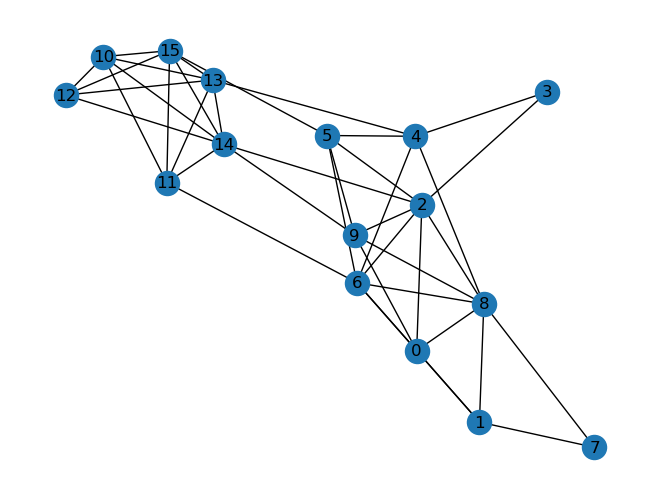

In [ ]:
graph_adj = np.array([[0., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
                      [1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
                      [1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.],
                      [0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
                      [0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
                      [0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
                      [1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
                      [0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
                      [1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
                      [1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
                      [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1.],
                      [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.],
                      [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1.],
                      [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1.],
                      [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.]])
graph = nx.from_numpy_array(graph_adj)
nx.draw(graph, with_labels=True)

In [ ]:
gbs = dqp.GBS_Graph(adj_mat=graph_adj, cutoff=2)
state = gbs()
sample = gbs.measure(shots=50000)

chain 5: 100%|█████████████████████████████| 9999/9999 [00:34<00:00, 290.53it/s]


下面对结果进行后选择，筛选出六个节点对应的采样结果，计算对应的图密度并从大到小排序

In [ ]:
subgraph_sample = gbs.postselect(sample, [6])
subgraph_density = gbs.graph_density(graph, subgraph_sample[0])
key = list(subgraph_density.keys())
print(key[0],subgraph_density[key[0]])

|0000000000111111> [29, 0.9333333333333333]


In [ ]:
subgraph_density

{|0000000000111111>: [29, 0.9333333333333333],
 |0010111011000000>: [49, 0.7333333333333333],
 |0000000001101111>: [8, 0.7333333333333333],
 |0000001000111011>: [18, 0.6666666666666666],
 |0010011011000010>: [1, 0.6666666666666666],
 |0110111010000000>: [21, 0.6666666666666666],
 |1010001011010000>: [12, 0.6666666666666666],
 |0000010000111101>: [20, 0.6666666666666666],
 |1011101010000000>: [26, 0.6666666666666666],
 |1111001010000000>: [5, 0.6666666666666666],
 |0000001000111110>: [6, 0.6666666666666666],
 |1010111001000000>: [7, 0.6666666666666666],
 |1100001111000000>: [11, 0.6666666666666666],
 |1110000111000000>: [27, 0.6666666666666666],
 |1110010011000000>: [6, 0.6666666666666666],
 |0010001000110110>: [30, 0.6],
 |1010000011000110>: [35, 0.6],
 |0000110000110101>: [42, 0.6],
 |1011100011000000>: [62, 0.6],
 |0000111000010101>: [10, 0.6],
 |0010010000001111>: [60, 0.6],
 |0000010001110011>: [10, 0.6],
 |0010010001000111>: [36, 0.6],
 |1010010001000011>: [43, 0.6],
 |00001100000

## 部分homodyne测量

高斯后端还可以对几个mode做部分测量，那么剩余的量子态会根据相应的测量结果塌缩，先通过`cir.homodyne`添加测量操作，`wires`表示作用单条线路，`phi`对应测量角度，然后通过`cir.measure_homodyne`进行测量操作实现量子态坍缩。

In [13]:
cir = dq.QumodeCircuit(nmode=2, init_state='vac', cutoff=3, backend='gaussian')
cir.s(wires=0, r=1)
cir.s(wires=1, r=1)
cir.d(wires=0, r=1)
cir.d(wires=1, r=1)
cir.bs(wires=[0,1], inputs=[np.pi/4,np.pi/4])
cir.homodyne(wires=0, phi=0)
#线路可视化
cir.draw()

In [14]:
state = cir()
sample = cir.measure_homodyne(shots=1) # 运行线路并进行一次采样
state_measured = cir.state_measured # 得到采样后坍缩的量子态

In [15]:
sample, state_measured

(tensor(1.0685),
 [tensor([[[ 1.0000,  0.0000,  0.0000,  0.0000],
           [ 0.0000,  1.9488,  0.0000, -1.8134],
           [ 0.0000,  0.0000,  1.0000,  0.0000],
           [ 0.0000, -1.8134,  0.0000,  2.2006]]]),
  tensor([[[0.0000],
           [2.4149],
           [0.0000],
           [0.1383]]])])

## 延时线圈组成的时分复用线路

通过`dq.QumodeCircuit`构造带延时线圈线路，通过`cir.delay`加入可调延时线圈，参数`wires` 表示作用的波导，`ntau`表示延时线圈内延时的个数，`inputs`表示延时线圈中可调参数，`convention` 对应两种，bs和mzi，对应延时线是`DelayBS`和`DelayMZI` 类型，默认是bs，对应一个单参数theta可调分束器和一个移相器。`encode`控制角度自由编码。

In [ ]:
r = 5
nmode = 2
cir = dq.QumodeCircuit(nmode=nmode, init_state='vac', cutoff=3, backend='gaussian')
cir.s(0)
cir.s(1)
cir.bs_theta([0,1], [3])
cir.delay(0, ntau=1, inputs=[3,0], encode=True)
cir.delay(1, ntau=1, inputs=[3,0], encode=True)
cir.homodyne(0)
cir.homodyne(1)
cir.draw()

`dq.QumodeCircuit` 构造带延时线的线路只能进行单个时间步线路演化，是通过`cir.draw(unroll=True)` 可以得到初次测量的等效的空间线路，然后演化等效空间线路得到最后的结果。

In [17]:
cir.draw(unroll=True)

In [18]:
state = cir()
state

[tensor([[[ 1.0089e+00, -6.7838e-02,  3.3727e-03, -1.5750e-03,  9.6701e-03,
            6.2609e-02,  2.2451e-04,  2.3660e-02],
          [-6.7838e-02,  8.7558e-01,  2.0884e-03, -1.6598e-01,  1.7736e-02,
           -4.7590e-01,  2.3660e-02,  1.4650e-02],
          [ 3.3727e-03,  2.0884e-03,  9.9952e-01, -9.4771e-02, -2.9769e-04,
            2.3660e-02,  1.3509e-02, -3.3836e-03],
          [-1.5750e-03, -1.6598e-01, -9.4771e-02,  1.5152e+00,  2.3660e-02,
           -1.1049e-02, -7.3433e-02, -6.6484e-01],
          [ 9.6701e-03,  1.7736e-02, -2.9769e-04,  2.3660e-02,  9.9747e-01,
            6.7838e-02, -3.3727e-03, -2.0884e-03],
          [ 6.2609e-02, -4.7590e-01,  2.3660e-02, -1.1049e-02,  6.7838e-02,
            1.4392e+00,  1.5750e-03,  1.6598e-01],
          [ 2.2451e-04,  2.3660e-02,  1.3509e-02, -7.3433e-02, -3.3727e-03,
            1.5750e-03,  1.0105e+00,  9.4771e-02],
          [ 2.3660e-02,  1.4650e-02, -3.3836e-03, -6.6484e-01, -2.0884e-03,
            1.6598e-01,  9.4771e-02

若要进行n次测量实验，得到对应的空间等效线路，可以通过`cir.global_circuit` 设置`nstep`得到，当设置`encode=True`的门必定不共享，因为是多个输入数据，`use_deepcopy`只控制变分参数的门是不是共享变分参数。

In [19]:
r = 5
nmode = 2
cir = dq.QumodeCircuit(nmode=nmode, init_state='vac', cutoff=3, backend='gaussian')
cir.s(0)
cir.s(1)
cir.bs_theta([0,1], [3])
cir.delay(0, ntau=1, inputs=[3,0], encode=True)
cir.delay(1, ntau=1, inputs=[3,0], encode=True)
cir.homodyne(0)
cir.homodyne(1)

In [20]:
cir_global = cir.global_circuit(nstep=3, use_deepcopy=True)
cir_global.draw(unroll=True) # draw global circuit

In [21]:
cir_global.ndata

12

当设置对应的`encode=True`，就可以自由编码global 线路的角度

In [22]:
data = torch.tensor([0]*cir_global.ndata)
state = cir_global(data=data)
cir_global.draw(unroll=True) # draw global circuit

通过`dq.QumodeCircuitTDM`也可以构造带延时线圈线路，它继承自`dq.QumodeCircuit`，不同之处在于可以进行多个时间步的演化，所有空间模式上都要求做Homodyne测量。

In [13]:
r = 5
nmode = 2
cir = dq.QumodeCircuitTDM(nmode=nmode, init_state='vac', cutoff=3)
cir.s(0)
cir.s(1)
cir.bs_theta([0,1], [3])
cir.delay(0, ntau=1, inputs=[3,0], encode=True)
cir.delay(1, ntau=1, inputs=[3,0], encode=True)
cir.homodyne(0)
cir.homodyne(1)
cir.draw()

通过`cir.samples`查看测量结果

In [14]:
cir(nstep=3)
sample = cir.samples
sample

tensor([[ 1.0318,  0.9105, -1.0059],
        [-0.1678,  1.4473, -1.5691]])

通过控制`encode=True`可以实现对不同时刻编码不同角度，从而制备不同的纠缠态，下面是EPR态的例子，第一次测量设置延时线圈参数为
$[\pi/2, \pi/2]$，第二次测量设置为$[\pi/4, 0]$，然后周期性重复角度测量可以得到纠缠的EPR态。

In [29]:
r = 9
nmode = 1
cir = dq.QumodeCircuitTDM(nmode=nmode, init_state='vac', cutoff=3)
cir.s(0, r=r)
cir.delay(0, ntau=1, inputs=[np.pi/2, np.pi/2], encode=True) # 参数编码
cir.homodyne_x(0)
data = torch.tensor([[np.pi/2, np.pi/2],
                      [np.pi/4, 0]]).unsqueeze(0) # 周期性参数组合
cir(data=data, nstep=13)
sample = cir.samples
sample

tensor([-3.9655e-01, -1.1962e+04, -1.1962e+04, -9.9409e+03, -9.9409e+03,
         1.6923e+03,  1.6923e+03, -4.3213e+03, -4.3213e+03, -4.5278e+03,
        -4.5278e+03, -8.1187e+03, -8.1187e+03])

# 基于Bosonic后端构建光量子线路

##  Bosonic 态

基于Bosonic后端的光量子线路演化的量子态是不再是高斯态，而是非高斯态，它对应的wigner函数可以写成多个高斯函数的线性叠加。\
$$ W(\xi) = \sum c_m G_{\mu_m, \Sigma_m}(\xi)$$
其中
$$G_{\boldsymbol{\mu},\boldsymbol{\Sigma}}(\boldsymbol{\xi})\equiv\frac{\exp\left[-\frac{1}{2}(\boldsymbol{\xi}-\boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\boldsymbol{\xi}-\boldsymbol{\mu})\right]}{\sqrt{\det(2\pi\boldsymbol{\Sigma})}}$$
$c_m$ 满足归一化条件，$\sum c_m = 1$。

我们用一组协方差矩阵，位移向量和权重来描述这样的非高斯态，这里我们称这种非高斯态为bosonic态。

和高斯态类似，通过Homodyne测量可以得到正交分量，设定测量角度为0或$\pi/2$得到的物理量是正交分量X或P的值，它们对应的分布满足边缘分布。

1. `BosonicState`

`BosonicState`作为Bosonic后端的一个类用来描述bosonic量子态，它的`state`参数可以有两种输入，`'vac'`对应着真空态，[cov, mean, weight] 对应自定义的bosonic态。
`nmode` 参数对应着这个态的模式数，它应该和输入的`state`维度匹配。`cutoff` 参数对应着光子截断数。

通过`BosonicState.cov`、`BosonicState.mean`、`BosonicState.weight`可以得到对应的协方差矩阵，位移向量和权重信息。

同时这个类也提供了计算wigner函数和边缘分布的功能，通过`BosonicState.wigner`和`BosonicState.marginal`函数调用，设置`plot=True`可以方便的实现可视化。

In [4]:
bosonic_state_1 = dq.BosonicState(state='vac', nmode=2, cutoff=3)
bosonic_state_2 = dq.BosonicState(state=[torch.eye(4).expand(2,4,4),torch.zeros(4).expand(2,4) + 0j,
                                         torch.tensor([0.5, 0.5])], nmode=2, cutoff=3)
print('state_1_cov_mean', bosonic_state_1.cov, bosonic_state_1.mean, bosonic_state_1.weight)
print('state_2_cov_mean', bosonic_state_2.cov, bosonic_state_2.mean, bosonic_state_2.weight)

state_1_cov_mean tensor([[[[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]]]]) tensor([[[[0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j]]]]) tensor([[1.+0.j]])
state_2_cov_mean tensor([[[[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]],

         [[1., 0., 0., 0.],
          [0., 1., 0., 0.],
          [0., 0., 1., 0.],
          [0., 0., 0., 1.]]]]) tensor([[[[0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j]],

         [[0.+0.j],
          [0.+0.j],
          [0.+0.j],
          [0.+0.j]]]]) tensor([[0.5000, 0.5000]])


E:\Anaconda\envs\dq_gpu\Lib\site-packages\matplotlib\contour.py:1515: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
E:\Anaconda\envs\dq_gpu\Lib\site-packages\matplotlib\contour.py:1516: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
E:\Anaconda\envs\dq_gpu\Lib\site-packages\numpy\ma\core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


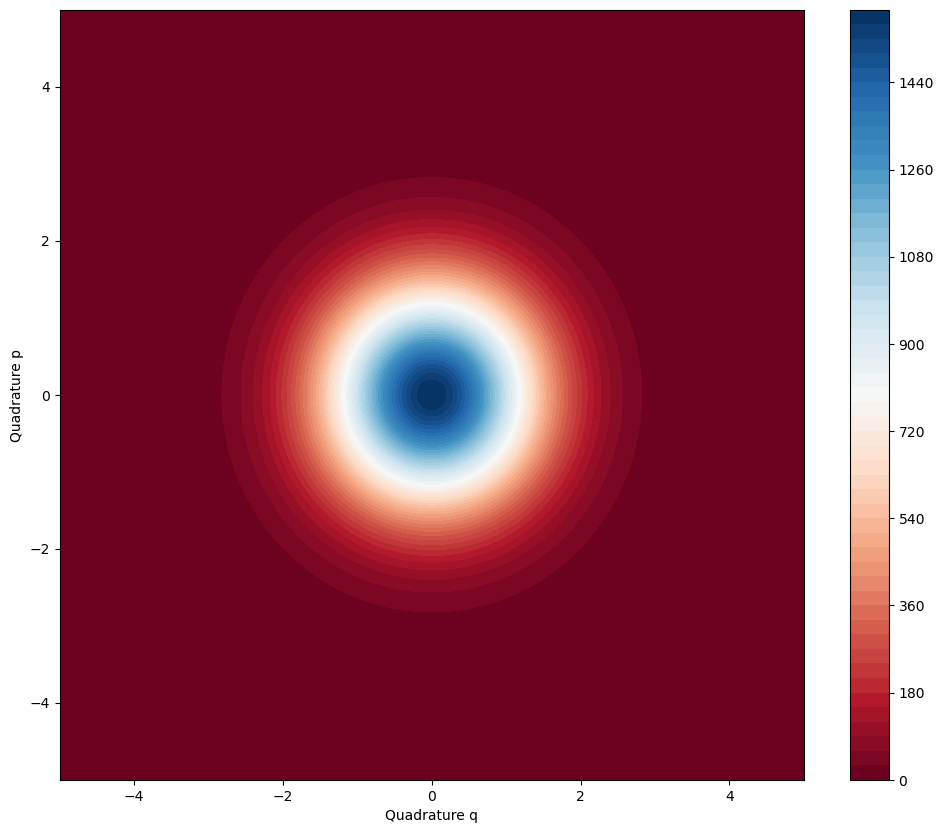

E:\Anaconda\envs\dq_gpu\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
E:\Anaconda\envs\dq_gpu\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


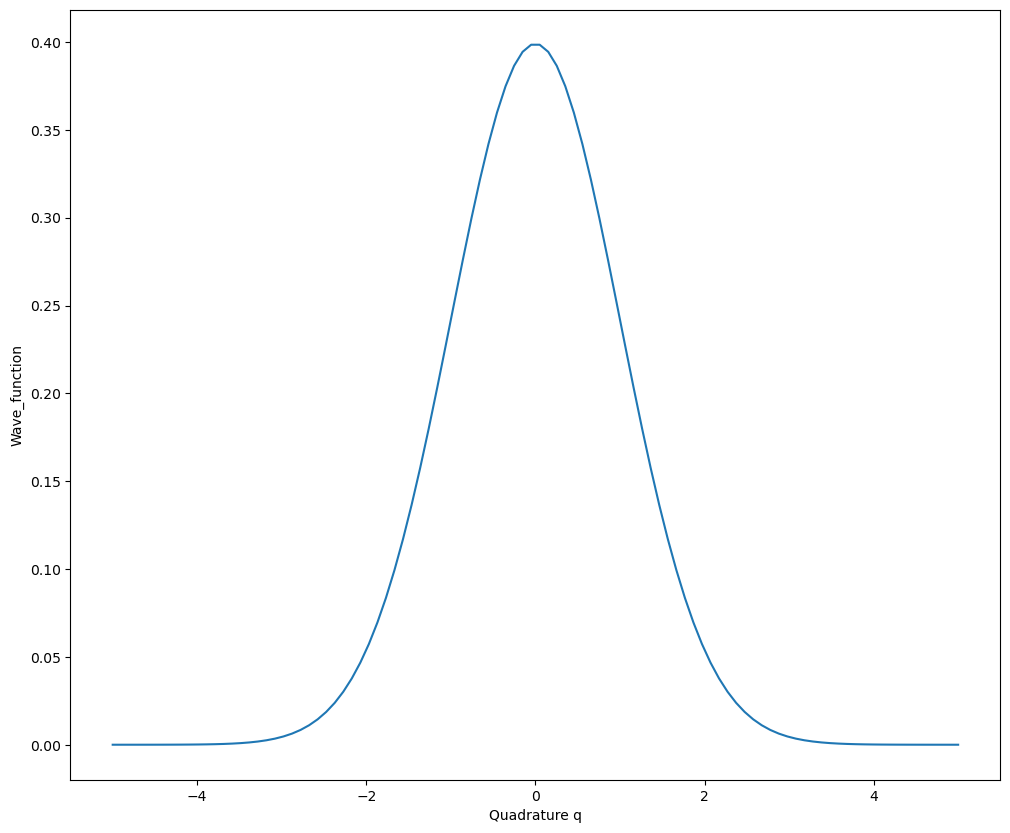

In [5]:
pvec = torch.linspace(-5, 5, 100)
qvec = torch.linspace(-5, 5, 100)
wigner = bosonic_state_1.wigner(wire=[0], qvec=qvec, pvec=pvec, plot=True) # wigner 函数可视化
marginal = bosonic_state_1.marginal(wire=[0], qvec=qvec, plot=True) # 边缘分布p(x)可视化

2. 猫态和GKP态

猫态和GKP态作为常见的bosonic态，可以在Bosonic后端中可以通过`dq.CatState`和`dq.GKPState`来自定义猫态和GKP。

猫态定义为两个相干态的线性叠加：
$$|k^{\alpha}\rangle_{\mathrm{cat}}=\sqrt{\mathcal{N}}\left(|\alpha\rangle+e^{i\pi k}|-{\alpha}\rangle\right)$$
这里$|\alpha\rangle$表示相干态，$k$ 是相位因子，$\mathcal{N}$ 是归一化因子。
$$\mathcal{N}=\frac{1}{2\left(1+e^{-|\alpha|^{2}}\cos(\pi k)\right)}$$
猫态的参数说明：
`r`表示相干态的对应的位移大小，`theta`表示相干态的对应的位移角度，`p`决定叠加系数是+1(`p=0`)还是-1(`p=1`)，`cutoff`表示fock态空间的截断数。

方形晶格形状的GKP态由一组狄拉克$\delta$ 函数决定，在位置正交分量下的GKP 0态和GKP 1态表示如下
$$\left|k\right\rangle_{\mathrm{gkp}}=\sum_{s=-\infty}^\infty\left|\sqrt{\pi\hbar}(2s+k)\right\rangle_q,k=\{0,1\}$$
采用GKP态编码量子比特，一般的量子态可以表示成
$$|\psi\rangle=\cos\frac{\theta}{2}|0\rangle_{\mathrm{gkp}}+e^{-i\phi}\sin\frac{\theta}{2}|1\rangle_{\mathrm{gkp}}$$
但是在实际模拟中一般会考虑有限能量的GKP态，即作用一个Fock阻尼算符$\hat{E}(\epsilon)$，
$$\hat{E}(\epsilon) = e^{-\epsilon \hat{n}}$$
此时的GKP态的狄拉克$\delta$ 函数变为一系列高斯波包，对应的包络为高斯函数。阻尼算符的作用下线性叠加的每一个高斯态的平均值和协方差也会相应更新。
$$\mu_m(\epsilon)=\frac{2e^{-\epsilon}}{1+e^{-2\epsilon}}\mu_m, \ \Sigma_m(\epsilon)=\frac{\hbar}{2}\frac{1-e^{-2\epsilon}}{1+e^{-2\epsilon}}\mathbb{1}$$
GKP态的参数说明：
`theta`表示Bloch球中的角度$\theta$，`phi`表示表示Bloch球中的角度$\phi$，`amp_cutoff`表示高斯包络的振幅截断，只保留截断范围以内的高斯波包，
`epsilon`表示阻尼算符的强度，`cutoff`表示fock态空间的截断数。

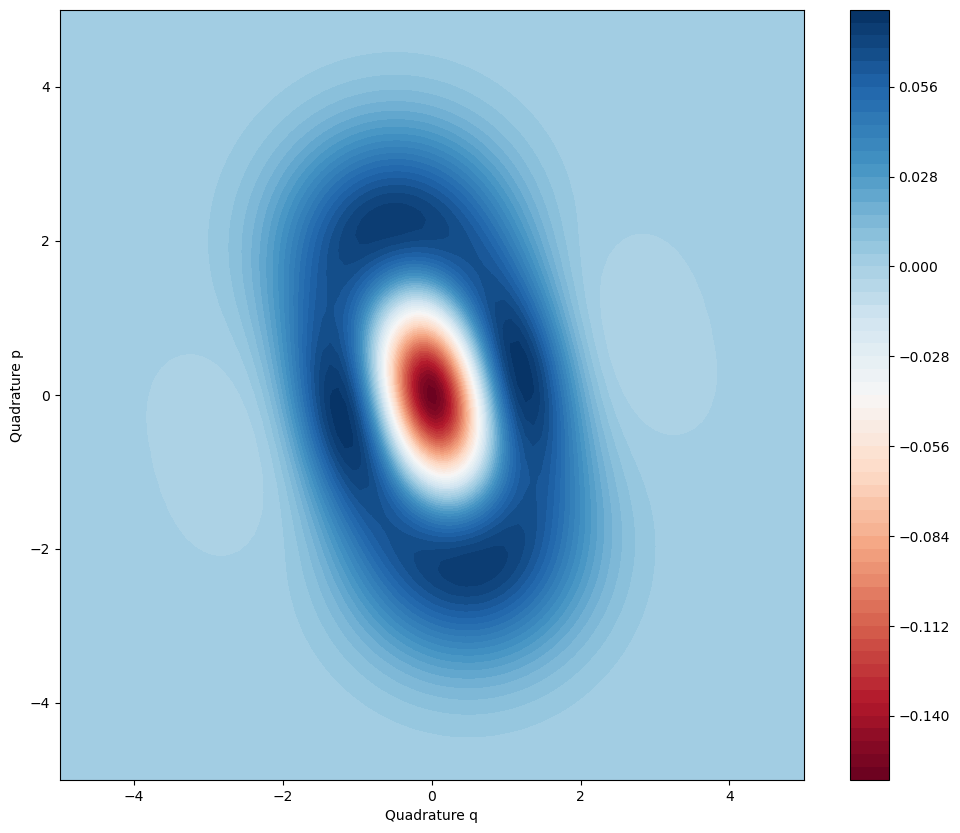

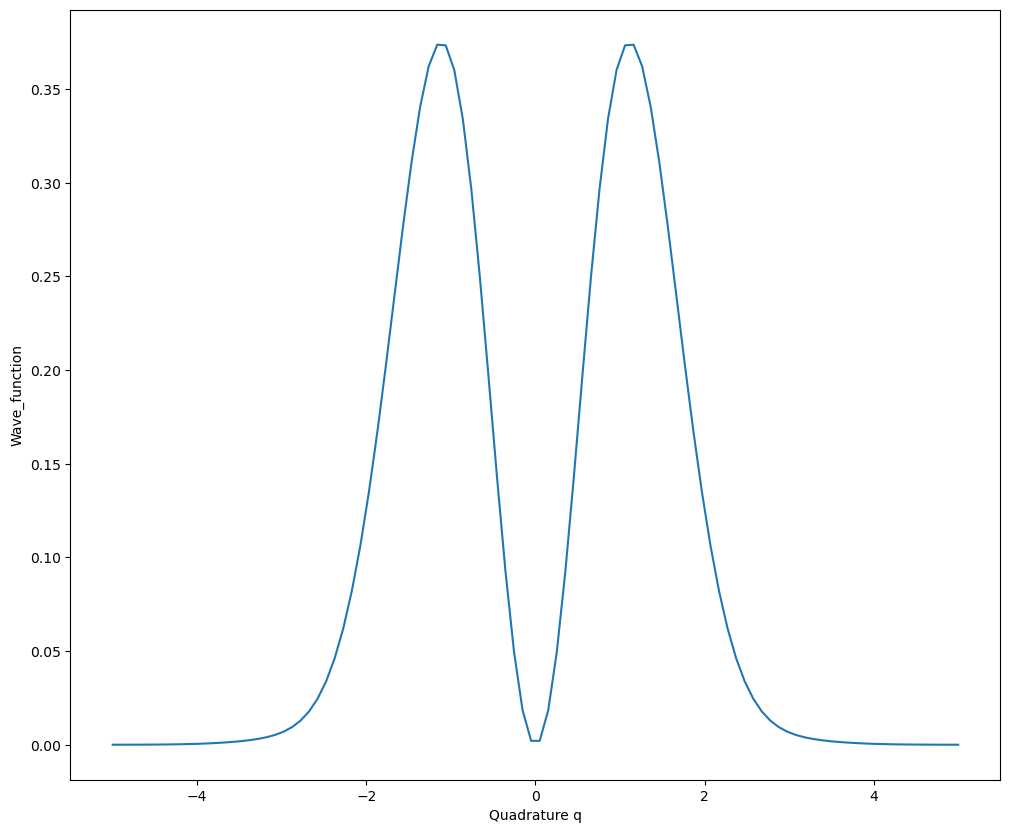

In [6]:
# 猫态实例化
cat = dq.CatState(r=1)
pvec = torch.linspace(-5, 5, 100)
qvec = torch.linspace(-5, 5, 100)
wigner = cat.wigner(wire=[0], qvec=qvec, pvec=pvec, plot=True) # wigner 函数可视化
marginal = cat.marginal(wire=[0], qvec=qvec, plot=True) # 边缘分布p(x)可视化

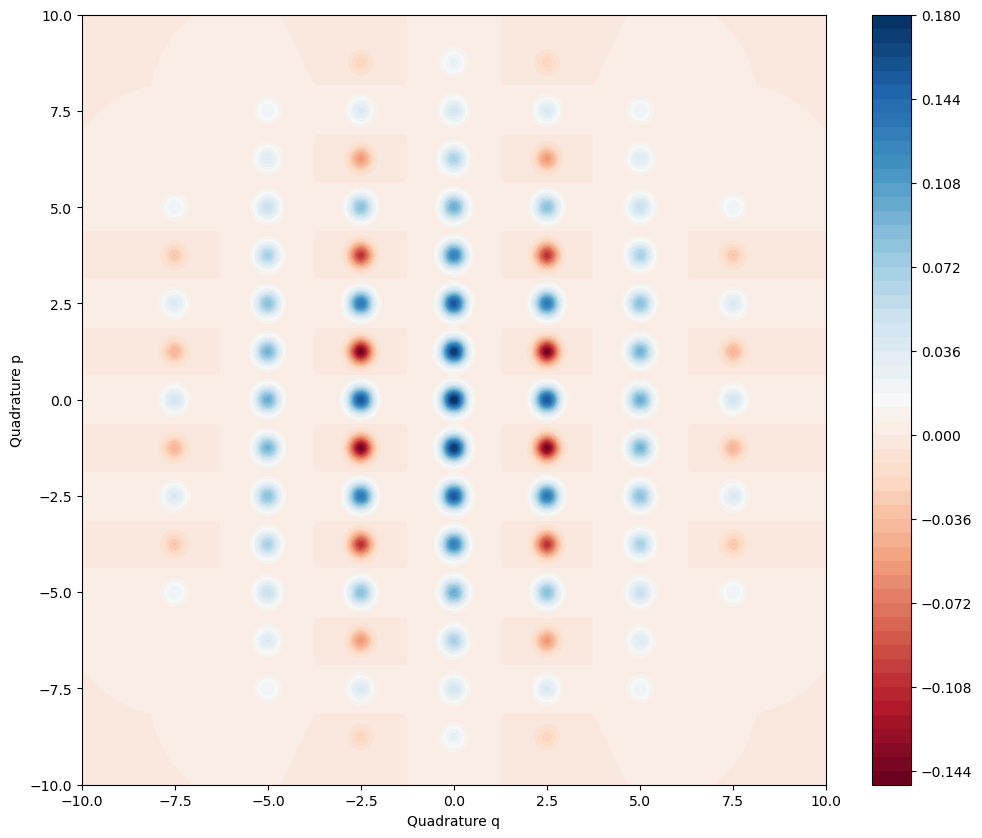

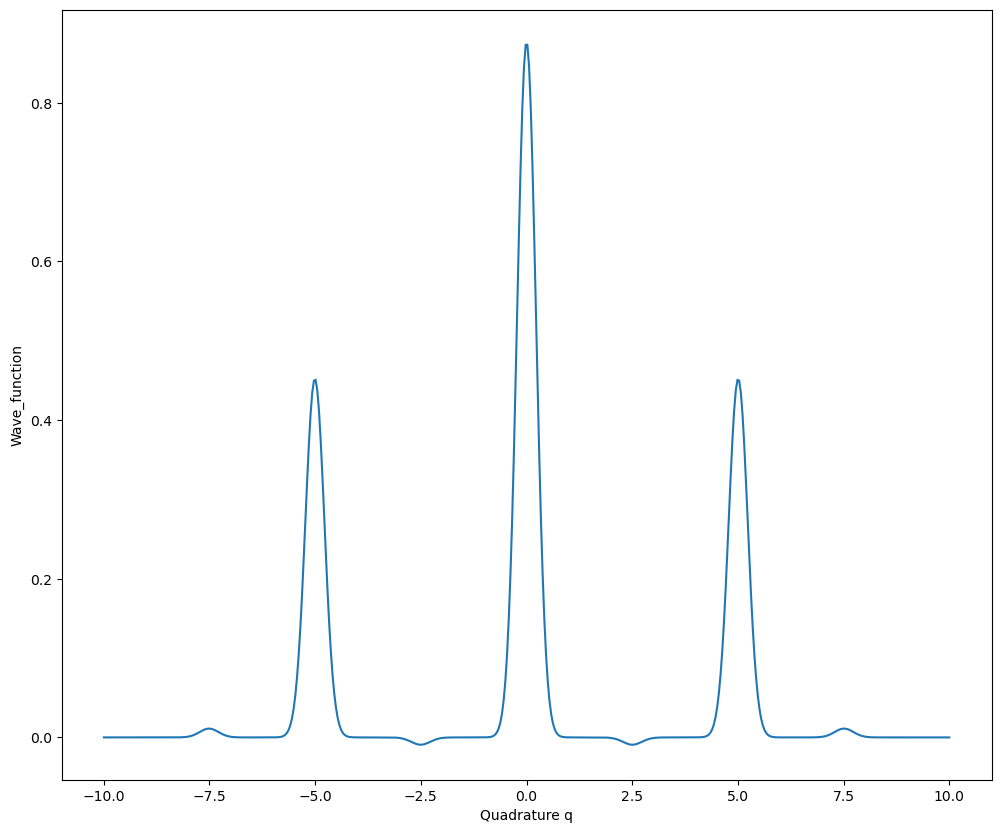

In [7]:
# GKP态实例化
gkp_0 = dq.GKPState(theta=0., phi=0.)
pvec = torch.linspace(-10, 10, 500)
qvec = torch.linspace(-10, 10, 500)
wigner = gkp_0.wigner(wire=[0], qvec=qvec, pvec=pvec, plot=True) # wigner 函数可视化
marginal = gkp_0.marginal(wire=[0], qvec=qvec, plot=True) # 边缘分布p(x)可视化

## Bosonic后端构建光量子线路

Bosonic后端构建光量子线路时要设置`backend`为`'bosonic'`，初态`init_state`设置可以为真空态`'vac'`，可以是自定义的[cov, mean, weight]，也可以通过`cir.cat`和`cir.gkp`自定义猫态和GKP态输入。

Bosonic后端的量子门和高斯后端是通用的，线路中的协方差矩阵，位移向量都遵循相同的辛变换规则，但是权重保持不变。
Bosonic后端的输出为包含协方差矩阵，位移向量以及权重的列表。

In [8]:
cir = dq.QumodeCircuit(nmode=2, init_state='vac', cutoff=3, backend='bosonic')
cir.cat(wires=0, r=1) # 设置猫态
cir.gkp(wires=1, theta=0., phi=0.) # 设置GKP态
cir.s(wires=0, r=1)
cir.s(wires=1, r=1)
cir.d(wires=0, r=1)
cir.d(wires=1, r=1)
cir.bs(wires=[0,1], inputs=[np.pi/4,np.pi/4])
state = cir()
for i in state:
    print(i.shape)

torch.Size([1, 1, 4, 4])
torch.Size([1, 356, 4, 1])
torch.Size([1, 356])


`cir.measure_homodyne` 对指定线路的正交分量进行测量，`shots`对应测量次数，`wires` 表示指定线路。

In [9]:
cir = dq.QumodeCircuit(nmode=2, init_state='vac', cutoff=3, backend='bosonic')
cir.cat(wires=0, r=1)
state = cir()
measure_re = cir.measure_homodyne(wires=[0], shots=100) #对正交分量进行测量， 这里的每个模对应一组正交分量X，P。
measure_re.shape

torch.Size([100, 2])

Bosonic后端还可以指定几个mode做部分测量，那么剩余的量子态会根据相应的测量结果塌缩，先通过`cir.homodyne`添加测量操作，`wires`表示作用单条线路，`phi`对应测量角度，然后通过`cir.measure_homodyne`进行测量操作实现量子态坍缩。

In [10]:
cir = dq.QumodeCircuit(nmode=2, init_state='vac', cutoff=3, backend='bosonic')
cir.cat(wires=0, r=1)
cir.homodyne(wires=0, phi=0)
state = cir()
measure_re = cir.measure_homodyne(shots=100) #对正交分量进行测量， 这里的每个模对应一个正交分量。
measure_re.shape

torch.Size([100])

通过设置 `is_prob=True` 参数也可以得到对应的Fock态概率分布，`detector='pnrd'` 表示使用粒子数分辨探测器，`detector='threshold'` 表示使用阈值探测器。

In [11]:
cir = dq.QumodeCircuit(nmode=2, init_state='vac', cutoff=3, backend='bosonic')
cir.cat(wires=0, r=1)
state = cir(is_prob=True, detector='threshold')
print(state)

{|00>: tensor([0.3679]), |01>: tensor([0.]), |10>: tensor([0.6321]), |11>: tensor([8.7709e-08])}
